In [1]:
# Bibliothèques utiles:
import torch
import torch.nn as nn

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert (self.head_dim * num_heads == embed_dim), "embed_dim must be divisible by num_heads"
        
        # Ce qu'il faut comprendre sur les entrées de cette classe, c'est qu'elles correspondent
        # précisément aux embeddings de:

        # Le -> [0.1, 0.6, ... , 0.3] de dimension 512 par exemple
        # chat -> [0.2, 0.4, ... , 0.5] de dimension 512 par exemple
        # mange -> [0.3, 0.1, ... , 0.7] de dimension 512 par exemple

        # Chaque entrée correspond à une partie différente de l'embedding et peut être
        # considérée comme une "vue" différente de l'embedding. 

        self.values = nn.Linear(embed_dim, embed_dim, bias=False)
        self.keys = nn.Linear(embed_dim, embed_dim, bias=False)
        self.queries = nn.Linear(embed_dim, embed_dim, bias=False)

        self.fc_out = nn.Linear(num_heads * self.head_dim, embed_dim)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]

        # Les termes suivants sont un peu abstraits mais ils correspondent de toute façon
        # toujours à la la longueur de la séquence en entrée et de celle en sortie
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # On applique les couches linéaires pour obtenir les valeurs, les clés et les requêtes
        values = self.values(values)  # [N, value_len, embed_dim]
        keys = self.keys(keys)        # [N, key_len, embed_dim] 
        queries = self.queries(query) # [N, query_len, embed_dim]

        # 1. Split embedding into multiple heads
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

        # 2. Calcul du score d'attention:
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) # Produit scalaire entre les requêtes et les clés
        # Queries shape :  (N, query_len, num_heads, head_dim)
        # Keys shape :    (N, key_len, num_heads, head_dim)
        # Energy shape :  (N, num_heads, query_len, key_len)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        # Pondération par les scores d'attention
        attention = torch.softmax(energy / (self.embed_dim ** (1/2) ), dim=3) # Conformément à la formule du papier

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.num_heads * self.head_dim)

        # Attention shape : (N, num_heads, query_len, key_len)
        # Values shape :    (N, value_len, num_heads, head_dim)
        # Out shape :       (N, query_len, num_heads, head_dim) after einsum puis flatten les deux dernières dimensions

        out = self.fc_out(out)
        return out 



In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):

        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query)) # Seulement la query est utilisée pour le résidu
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [4]:
class Encoder(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            embed_size,
            num_layers,
            num_heads,
            device,
            forward_expansion,
            dropout,
            max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    num_heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                ) for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)


    def forward(self, x, mask):
        N, seq_length = x.shape

        # torch.arange = similaire à np.arange mais pour PyTorch
        # Il crée un tenseur de la forme [0, 1, 2, ..., seq_length-1]
        # expand(N, seq_length) répète ce tenseur N fois pour chaque batch
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            out = layer(out, out, out, mask) # Surprenant que toutes les entrées soient les mêmes, mais c'est comme ça que ça marche

        return out
        

In [5]:
class SentimentModel(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 embed_size,
                 num_layers,
                 num_heads,
                 forward_expansion,
                 dropout,
                 max_length,
                 device,
                 num_classes=3):
        
        super(SentimentModel, self).__init__()

        self.encoder = Encoder(
            src_vocab_size=src_vocab_size,
            embed_size=embed_size,
            num_layers=num_layers,
            num_heads=num_heads,
            device=device,
            forward_expansion=forward_expansion,
            dropout=dropout,
            max_length=max_length
        )

        self.classifier = nn.Sequential(
            nn.Linear(embed_size, embed_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_size // 2, num_classes)
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x, mask=None):
        encoded = self.encoder(x, mask)

        pooled = encoded.mean(dim=1)

        logits = self.classifier(pooled)
        
        return logits

In [7]:
"""
Mini-projet : Entraîner le modèle sur des données de sentiment
"""

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 10000  # Taille du vocabulaire

# 🎯 TON MODÈLE avec TON ENCODER
model = SentimentModel(
    src_vocab_size=vocab_size,
    embed_size=512,
    num_layers=6,      # 6 couches d'encoder
    num_heads=8,       # 8 têtes d'attention
    device=device,
    forward_expansion=4,
    dropout=0.1,
    max_length=128,    # Phrases jusqu'à 128 tokens
    num_classes=3      # Pos/Neg/Neutral
).to(device)

# Exemple de données (batch)
batch_size = 32
seq_len = 50

# Données factices pour test
input_ids = torch.randint(1, vocab_size, (batch_size, seq_len)).to(device)
labels = torch.randint(0, 3, (batch_size,)).to(device)

# Masque de padding (1 = token réel, 0 = padding)
mask = None

# Forward pass
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model.train()

# 🚀 ENTRAÎNEMENT
for epoch in range(5):
    optimizer.zero_grad()
    
    # 1. Forward : TON ENCODER fait le travail lourd
    logits = model(input_ids, mask)
    
    # 2. Loss et backward
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    
    # 3. Métriques
    predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == labels).float().mean()
    
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")


Epoch 1: Loss = 1.0903, Accuracy = 0.4375
Epoch 2: Loss = 1.0899, Accuracy = 0.4062
Epoch 3: Loss = 1.0705, Accuracy = 0.4062
Epoch 4: Loss = 1.0667, Accuracy = 0.4062
Epoch 5: Loss = 1.0832, Accuracy = 0.3438


In [8]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer

def load_imdb_dataset():
    """
    🎬 Dataset IMDb : 50k reviews de films (25k train, 25k test)
    Labels : 0 = Négatif, 1 = Positif
    Parfait pour commencer !
    """
    
    # Chargement automatique
    dataset = load_dataset("imdb")
    
    print(f"📊 Train: {len(dataset['train'])} samples")
    print(f"📊 Test: {len(dataset['test'])} samples")
    print(f"📋 Exemple: {dataset['train'][0]}")
    
    return dataset

# 🔧 INTÉGRATION avec ton modèle
def prepare_imdb_for_training():
    dataset = load_dataset("imdb")
    
    # Tokenizer simple (ou utilise le tien)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    def tokenize_function(examples):
        # Tokenize et tronque à max_length
        return tokenizer(
            examples['text'], 
            truncation=True, 
            padding='max_length', 
            max_length=512,
            return_tensors="pt"
        )
    
    # Applique la tokenisation
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    
    # Conversion en DataLoader PyTorch
    from torch.utils.data import DataLoader
    
    train_loader = DataLoader(
        tokenized_dataset['train'], 
        batch_size=32, 
        shuffle=True
    )
    
    return train_loader, tokenized_dataset

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


🚀 Démarrage de l'entraînement sentiment analysis IMDb
📱 Device utilisé: cpu
🔧 Création du modèle...
📊 Paramètres du modèle: 11,035,522
📊 Chargement des données...


Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 394807.07 examples/s]
tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<00:00, 126kB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 2.64MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.18MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.13MB/s]


🔄 Tokenisation en cours...


Map: 100%|██████████| 25000/25000 [00:04<00:00, 5834.31 examples/s]


🎯 Début de l'entraînement...

📅 EPOCH 1/3
----------------------------------------
🔄 Entraînement en cours...


Training: 100%|██████████| 1563/1563 [03:45<00:00,  6.93it/s]


🔄 Train Loss: 0.6727 | Train Acc: 0.5726
🔍 Évaluation en cours...


Evaluating: 100%|██████████| 1563/1563 [01:11<00:00, 21.78it/s]


🔍 Val Loss: 0.6289 | Val Acc: 0.6488
💾 Modèle sauvegardé: best_sentiment_model_epoch_1.pth
🏆 Nouveau meilleur modèle! Acc: 0.6488

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.64      0.64     12500
    Positive       0.64      0.66      0.65     12500

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000


📅 EPOCH 2/3
----------------------------------------
🔄 Entraînement en cours...


Training: 100%|██████████| 1563/1563 [03:49<00:00,  6.80it/s]


🔄 Train Loss: 0.6107 | Train Acc: 0.6636
🔍 Évaluation en cours...


Evaluating: 100%|██████████| 1563/1563 [01:13<00:00, 21.22it/s]


🔍 Val Loss: 0.6076 | Val Acc: 0.6772
💾 Modèle sauvegardé: best_sentiment_model_epoch_2.pth
🏆 Nouveau meilleur modèle! Acc: 0.6772

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.57      0.64     12500
    Positive       0.64      0.79      0.71     12500

    accuracy                           0.68     25000
   macro avg       0.69      0.68      0.67     25000
weighted avg       0.69      0.68      0.67     25000


📅 EPOCH 3/3
----------------------------------------
🔄 Entraînement en cours...


Training: 100%|██████████| 1563/1563 [03:40<00:00,  7.08it/s]


🔄 Train Loss: 0.5836 | Train Acc: 0.6893
🔍 Évaluation en cours...


Evaluating: 100%|██████████| 1563/1563 [01:12<00:00, 21.66it/s]


🔍 Val Loss: 0.6183 | Val Acc: 0.6762

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.48      0.60     12500
    Positive       0.63      0.87      0.73     12500

    accuracy                           0.68     25000
   macro avg       0.71      0.68      0.66     25000
weighted avg       0.71      0.68      0.66     25000


🎉 ENTRAÎNEMENT TERMINÉ!
🏆 Meilleure accuracy validation: 0.6772
📈 Graphiques sauvegardés dans 'training_results.png'


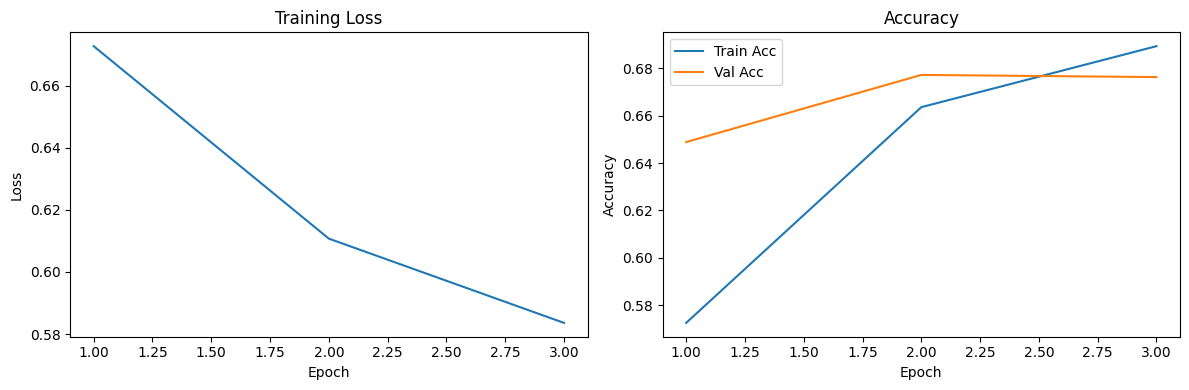

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# 📊 Tes fonctions de dataset (déjà définies)
from datasets import load_dataset
from transformers import AutoTokenizer

def load_imdb_dataset():
    dataset = load_dataset("imdb")
    print(f"📊 Train: {len(dataset['train'])} samples")
    print(f"📊 Test: {len(dataset['test'])} samples")
    print(f"📋 Exemple: {dataset['train'][0]}")
    return dataset

def prepare_imdb_for_training(max_length=128, batch_size=32):
    """Version adaptée pour ton modèle"""
    dataset = load_dataset("imdb")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    def tokenize_function(examples):
        return tokenizer(
            examples['text'], 
            truncation=True, 
            padding='max_length', 
            max_length=max_length,
            return_tensors="pt"
        )
    
    # Tokenise les datasets
    print("🔄 Tokenisation en cours...")
    tokenized_train = dataset['train'].map(tokenize_function, batched=True)
    tokenized_test = dataset['test'].map(tokenize_function, batched=True)
    
    # Prépare les DataLoaders
    tokenized_train.set_format(type='torch', columns=['input_ids', 'label'])
    tokenized_test.set_format(type='torch', columns=['input_ids', 'label'])
    
    train_loader = DataLoader(tokenized_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(tokenized_test, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# 🎯 CLASSE D'ENTRAÎNEMENT
class SentimentTrainer:
    def __init__(self, model, device, learning_rate=2e-5):
        self.model = model
        self.device = device
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.train_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, train_loader):
        """Un epoch d'entraînement"""
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        print("🔄 Entraînement en cours...")
        for batch in tqdm(train_loader, desc="Training"):
            # Récupère les données
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['label'].to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            
            try:
                # Utilise ton modèle (sans masque pour commencer)
                logits = self.model(input_ids, mask=None)
                loss = self.criterion(logits, labels)
                
                # Backward pass
                loss.backward()
                self.optimizer.step()
                
                # Métriques
                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            except Exception as e:
                print(f"❌ Erreur dans le batch: {e}")
                continue
        
        # Calcul des métriques moyennes
        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
        
        return avg_loss, accuracy
    
    def evaluate(self, test_loader):
        """Évaluation sur le dataset de test"""
        self.model.eval()
        all_predictions = []
        all_labels = []
        total_loss = 0
        
        print("🔍 Évaluation en cours...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['label'].to(self.device)
                
                try:
                    logits = self.model(input_ids, mask=None)
                    loss = self.criterion(logits, labels)
                    
                    total_loss += loss.item()
                    predictions = torch.argmax(logits, dim=1)
                    
                    all_predictions.extend(predictions.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                except Exception as e:
                    print(f"❌ Erreur dans l'évaluation: {e}")
                    continue
        
        avg_loss = total_loss / len(test_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        report = classification_report(all_labels, all_predictions, 
                                     target_names=['Negative', 'Positive'])
        
        self.val_accuracies.append(accuracy)
        
        return avg_loss, accuracy, report
    
    def save_model(self, path):
        """Sauvegarde le modèle"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
        }, path)
        print(f"💾 Modèle sauvegardé: {path}")

# 🚀 SCRIPT D'ENTRAÎNEMENT PRINCIPAL
def main_training():
    print("🚀 Démarrage de l'entraînement sentiment analysis IMDb")
    print("="*60)
    
    # Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📱 Device utilisé: {device}")
    
    # Hyperparamètres
    VOCAB_SIZE = 30522  # Taille vocab BERT
    EMBED_SIZE = 256
    NUM_LAYERS = 4
    NUM_HEADS = 8
    MAX_LENGTH = 128
    BATCH_SIZE = 16  # Réduit pour éviter les problèmes de mémoire
    NUM_EPOCHS = 3
    LEARNING_RATE = 2e-5
    
    # Création du modèle (utilise ta classe SentimentClassifier)
    print("🔧 Création du modèle...")
    model = SentimentModel(
        src_vocab_size=VOCAB_SIZE,
        embed_size=EMBED_SIZE,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        device=device,
        forward_expansion=4,
        dropout=0.1,
        max_length=MAX_LENGTH,
        num_classes=2  # Binaire: Positif/Négatif
    ).to(device)
    
    print(f"📊 Paramètres du modèle: {sum(p.numel() for p in model.parameters()):,}")
    
    # Chargement des données
    print("📊 Chargement des données...")
    train_loader, test_loader = prepare_imdb_for_training(
        max_length=MAX_LENGTH, 
        batch_size=BATCH_SIZE
    )
    
    # Trainer
    trainer = SentimentTrainer(model, device, learning_rate=LEARNING_RATE)
    
    # Boucle d'entraînement
    print("🎯 Début de l'entraînement...")
    print("="*60)
    
    best_val_acc = 0.0
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n📅 EPOCH {epoch+1}/{NUM_EPOCHS}")
        print("-" * 40)
        
        # Entraînement
        train_loss, train_acc = trainer.train_epoch(train_loader)
        print(f"🔄 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Évaluation
        val_loss, val_acc, report = trainer.evaluate(test_loader)
        print(f"🔍 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # Sauvegarde du meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            trainer.save_model(f'best_sentiment_model_epoch_{epoch+1}.pth')
            print(f"🏆 Nouveau meilleur modèle! Acc: {best_val_acc:.4f}")
        
        print(f"\n📊 Classification Report:")
        print(report)
        print("="*60)
    
    # Résultats finaux
    print("\n🎉 ENTRAÎNEMENT TERMINÉ!")
    print(f"🏆 Meilleure accuracy validation: {best_val_acc:.4f}")
    
    # Graphique des résultats (optionnel)
    try:
        import matplotlib.pyplot as plt
        
        epochs = range(1, len(trainer.train_accuracies) + 1)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, trainer.train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, trainer.train_accuracies, label='Train Acc')
        plt.plot(epochs, trainer.val_accuracies, label='Val Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_results.png')
        print("📈 Graphiques sauvegardés dans 'training_results.png'")
        
    except ImportError:
        print("📊 Matplotlib pas installé, pas de graphiques générés")
    
    return model, trainer

# 🎯 FONCTION DE TEST RAPIDE
def quick_test():
    """Test rapide pour vérifier que tout fonctionne"""
    print("🧪 Test rapide du pipeline...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Modèle minimal
    model = SentimentModel(
        src_vocab_size=30522,
        embed_size=128,  # Plus petit pour le test
        num_layers=2,    # Moins de layers
        num_heads=4,
        device=device,
        num_classes=2,
        max_length=64
    ).to(device)
    
    # Données minimales
    train_loader, test_loader = prepare_imdb_for_training(max_length=64, batch_size=4)
    
    # Test sur un batch
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        
        logits = model(input_ids, mask=None)
        print(f"✅ Shape input: {input_ids.shape}")
        print(f"✅ Shape output: {logits.shape}")
        print(f"✅ Labels: {labels.shape}")
        break
    
    print("🎉 Test réussi! Le pipeline fonctionne.")



model, trainer = main_training()
